### Импортирование библиотек

In [1]:
# Для расчётов и хранения данных
import pandas as pd
import numpy as np
import ot
import ot.plot
pd.set_option("display.max_columns", None)

In [2]:
# Для графиков
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path

### 1. Осуществить чтение данных из двух csv файлов

In [3]:
# file: NY_Accidents_Dec21.csv
a_data = pd.read_csv("NY_Accidents_Dec21.csv")
print(a_data.shape)
#a_data[-10:]

(108049, 47)


In [4]:
# file: new_york_hotels.csv
hotels_data = pd.read_csv("new_york_hotels.csv")
print(hotels_data.shape)
#hotels_data[-10:]

(1631, 11)


### 2. Сформировать две выборки

In [5]:
# - Из датафрейма местоположений отелей
# сформировать датафрейм, содержащий широту и долготу
h_coords = hotels_data[hotels_data["city"] == "New York"]
h_coords = h_coords[["latitude", "longitude"]].copy()
print(h_coords.shape)

(401, 2)


In [6]:
# - Из датафрейма местоположений автомобилей
# сформировать датафрейм, состоящий из значения
# широты и долготы в городе Нью-Йорк
a_coords = a_data[a_data["City"] == "New York"]
a_coords = a_coords[["Start_Lat", "Start_Lng"]].copy()
print(a_coords.shape)

(7068, 2)


In [7]:
# - Сбалансировать размерности выборок
n1 = 150
n2 = 150;
b_a_coords = a_coords[:n1]
b_h_coords = h_coords[-n2:]

### 3. Вывести график местоположений пунктов назначения и расположений машин такси

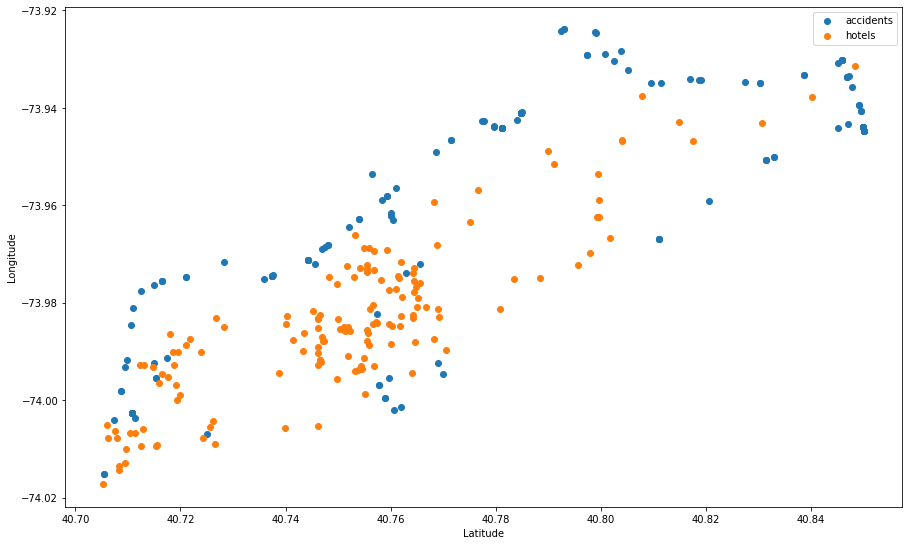

In [8]:
# - разными цветами в одной координатной плоскости
fig, ax = plt.subplots()
fig.set_figheight(9.2)
fig.set_figwidth(15)
ax.scatter(b_a_coords["Start_Lat"], b_a_coords["Start_Lng"], label="accidents")
ax.scatter(b_h_coords["latitude"], b_h_coords["longitude"], label="hotels")
plt.legend(loc=0)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

### 4. Рассчитайте расстояние между точками из двух сформированных ранее датафреймов

In [9]:
# Рассчёт расстояния между точками датафреймов
d_matrix = ot.dist(b_a_coords.values, b_h_coords.values)
# Нормирование расстояния
d_matrix /= d_matrix.max()
d_matrix = pd.DataFrame(d_matrix)
#d_matrix[-15:]

Text(0.5, 1.0, 'Матрица расстояний')

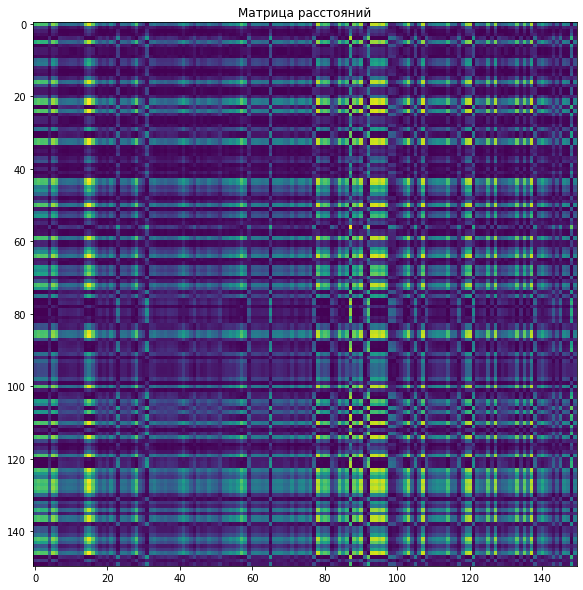

In [10]:
# Вывод матрицы расстояний на график
plt.figure(2, figsize=(10, 10))
plt.imshow(d_matrix.values, interpolation="nearest")
plt.title("Матрица расстояний")

### 5. Найдите матрицу оптимальных перемещений

In [11]:
# Получаем данные от POT об оптимальных перемещениях
a, b = np.ones((n1,)) / n1, np.ones((n2,)) / n2
G0 = ot.emd(a, b, d_matrix.values)

Text(0, 0.5, 'Longitude')

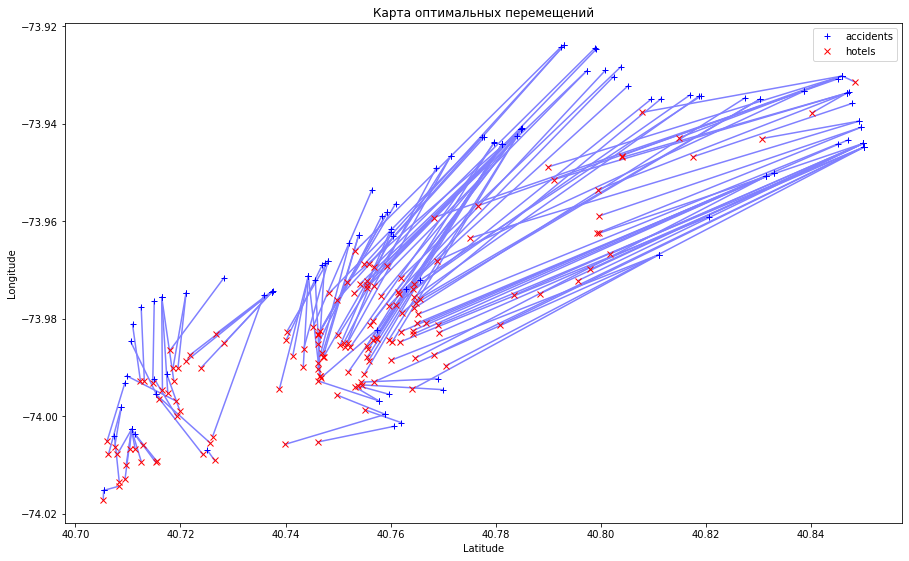

In [12]:
# Строим график (карту)
plt.figure(3, figsize=(15, 9.2))
ot.plot.plot2D_samples_mat(b_a_coords.values, b_h_coords.values, G0, c=[.5, .5, 1])
plt.plot(b_a_coords["Start_Lat"], b_a_coords["Start_Lng"], "+b", label="accidents", )
plt.plot(b_h_coords["latitude"], b_h_coords["longitude"], "xr", label="hotels", )
plt.legend(loc=0)

# Или матрица оптимальных перемещений
plt.title("Карта оптимальных перемещений")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

### 6. Сформируйте датафрейм, содержащий данные по оптимальным местоположениям отелей и такси

In [13]:
# Выбираем оптимальное местоположение
ID_h = 0
ID_a = 0
table = []
for row in G0:
    ID_h = 0
    for elem in row:
        if (elem > 0.0):
            table.append([ID_a, ID_h])
            break
        ID_h += 1
    ID_a += 1
table = pd.DataFrame(table)
table.columns = ['ID_taxi', 'ID_hotel']
table

,ID_taxi,ID_hotel
0,0,108
1,1,52
2,2,68
3,3,111
4,4,127
...,...,...
145,145,18
146,146,92
147,147,107
148,148,33


In [14]:
# Сохранить датафрейм
table.to_csv("links.csv", encoding="utf-8", index=False)

### Создайте два csv файла, которые содержат данные о местоположениях в соответствии с оптимальными маршрутами. 

In [15]:
# Функция подготовки фреймов
def preparing(df):
    df = df.reset_index(drop=True)
    df["ID"] = df.index
    _id = df["ID"]
    df.drop(labels=["ID"], axis=1, inplace = True)
    df.insert(0, "ID", _id)
    return df

In [16]:
# Подготовка фреймов
b_h_coords = preparing(b_h_coords)
b_a_coords = preparing(b_a_coords)
b_h_coords.to_csv("hotels.csv", encoding="utf-8", index=False)
b_a_coords.to_csv("taxi.csv", encoding="utf-8", index=False)

In [18]:
'''
TEST
'''
ID_h = 0
ID_t = 0
table = []
for row in G0:
    ID_h = 0
    for elem in row:
        if (elem > 0.0):
            table.append([b_a_coords["Start_Lat"][ID_t],
                          b_a_coords["Start_Lng"][ID_t],
                          b_h_coords["latitude"][ID_h],
                          b_h_coords["longitude"][ID_h]])
            #table.append([ID_t, ID_h])
            break
        ID_h += 1
    ID_t += 1
table = pd.DataFrame(table)
table.columns = ['taxi_lat', 'taxi_lng', 'hotel_lat', 'hotel_lng']
table.to_csv("all.csv", encoding="utf-8", index=False)
table

,taxi_lat,taxi_lng,hotel_lat,hotel_lng
0,40.850020,-73.943990,40.78850,-73.97483
1,40.771460,-73.946580,40.75186,-73.98488
2,40.762979,-73.973938,40.75197,-73.99090
3,40.744340,-73.971240,40.74338,-73.98999
4,40.710680,-74.002720,40.71137,-74.00669
...,...,...,...,...
145,40.799120,-73.924709,40.75927,-73.96924
146,40.847280,-73.933410,40.84023,-73.93775
147,40.710680,-74.002720,40.70944,-74.01299
148,40.768730,-73.948980,40.75109,-73.98495
